# Comparación de una simulación OpenMC con los resultados de un archivo de "tracks".

## Objetivo

El objetivo de este cuaderno es, con un cubo de agua que tiene una fuente en una de sus caras, comparar los resultados de la corriente de neutrones a la salida del cubo (es decir, en la cara opuesta a la fuente) en función de las variables x, y, theta, phi mu y la energía de una simulación openmc con datos del archivo "tracks". 

## Ayuda

Importación de varias bibliotecas útiles para el tratamiento de código y datos.

In [2]:
import pandas as pd
import h5py 
import numpy as np
import matplotlib.pyplot as plt
import openmc
import os 
from matplotlib.colors import LogNorm
from uncertainties import ufloat, unumpy  #imprimir numeros con mas menos

In [3]:
openmc_data = "/Users/gregoire_lebreton/anaconda3/envs/internship/endfb-viii.0-hdf5/cross_sections.xml"
os.environ["OPENMC_CROSS_SECTIONS"] = openmc_data
openmc.config['cross_sections'] = openmc_data

## Materiales

Definición del material utilizado, es decir, el agua.

In [84]:
mat=openmc.Material(material_id=2)
mat.add_nuclide("H1",2)
mat.add_nuclide("O16",1)
mat.add_s_alpha_beta('c_H_in_H2O') # Thermal Scattering Law
mat.set_density('g/cm3', 1)

/Users/gregoire_lebreton/anaconda3/envs/internship/lib/python3.11/site-packages/openmc/mixin.py:70: IDWarning: Another Material instance already exists with id=2.
  warn(msg, IDWarning)


## Geometría

Definición de geometría. Para este código utilizamos un cubo de 10 cm lleno de agua y con vacío en el exterior. 

In [5]:
Lx,Ly,Lz=10.0,10.0,10.0

surf01=openmc.XPlane(boundary_type = "vacuum", surface_id = 1)
surf02=openmc.YPlane(boundary_type = "vacuum", surface_id = 2)
surf03=openmc.ZPlane(boundary_type = "vacuum", surface_id = 3) 
surf04=openmc.XPlane(Lx,boundary_type = "vacuum", surface_id = 4)
surf05=openmc.YPlane(Ly,boundary_type = "vacuum", surface_id = 5)
surf06=openmc.ZPlane(Lz,boundary_type = "vacuum", surface_id = 6)

cell=openmc.Cell(region = +surf01 & -surf04 & +surf02 & -surf05 & +surf03 & -surf06, fill=mat , cell_id = 1 )

univ=openmc.Universe(cells = [cell], universe_id = 1)

## Parámetros

Definición de los parámetros. Aquí vamos a generar una simulación con 1e8 partículas 1 batches y todos con el modo de funcionamiento "fixed source". Y generación del archivo "surface_source.h5", es decir, el archivo de "tracks".

In [6]:
sets = openmc.Settings()
sets.run_mode = "fixed source"
sets.particles = 100000000
sets.batches = 1
sets.inactive = 0
sets.photon_transport = True

sets.surf_source_write = {
    'surface_ids': [6],
    'max_particles': 100000000
}

## Fuente

Definición de la fuente monoenergética en la superficie (z=0) y con una distribución espacial coseno.

In [7]:
E_f=1.0e6 # fuente mono energia [eV]

In [8]:
X=np.linspace(0,Lx,50)
Y=np.linspace(0,Ly,50)
PX=np.sin(np.pi*X/(Lx)) #distribución espacial en cos
PY=np.sin(np.pi*Y/Ly) # distribución espacial en cos
Z=[1e-6,]
PZ=[1.0,]
print(Z)

source=openmc.Source()
source.space = openmc.stats.CartesianIndependent(openmc.stats.Tabular(X,PX),openmc.stats.Tabular(Y,PY),openmc.stats.Discrete(Z,PZ)) #cos distribucion 

source.energy = openmc.stats.Discrete([E_f], [1.0]) #mono-energia
sets.source=source

[1e-06]


## Tallies

Definición de las distintas grillas, filtros y tallies útiles.

In [137]:
tallies = openmc.Tallies()

# Grillas

mesh_x = openmc.RegularMesh(mesh_id = 1)
mesh_x.lower_left = [0, 0, Lz-0.99999*Lz] # volumen infinitesimal 
mesh_x.upper_right = [Lx, Ly, Lz]
mesh_x.dimension = [50, 1, 1]

mesh_y = openmc.RegularMesh(mesh_id = 2)
mesh_y.lower_left = [0, 0, Lz-0.99999*Lz] # volumen infinitesimal 
mesh_y.upper_right = [Lx, Ly, Lz]
mesh_y.dimension = [1, 50, 1]

mesh_xy = openmc.RegularMesh(mesh_id = 3)
mesh_xy.lower_left = [0, 0, Lz-0.99999*Lz] #volumen infinitesimal 
mesh_xy.upper_right = [Lx, Ly, Lz]
mesh_xy.dimension = [50, 50, 1]

mesh = openmc.RegularMesh(mesh_id = 4)
mesh.lower_left = [0, 0, Lz-0.99999*Lz] # volumen infinitesimal 
mesh.upper_right = [Lx, Ly, Lz]
mesh.dimension = [1, 1, 1]

#Filtros de grilla 

filter_mesh_x = openmc.filter.MeshFilter(mesh_x, filter_id = 1)
filter_mesh_y = openmc.filter.MeshFilter(mesh_y, filter_id = 2)
filter_mesh_xy = openmc.filter.MeshFilter(mesh_xy, filter_id = 3)
filter_mesh = openmc.filter.MeshFilter(mesh, filter_id=4)

#Filtros de angulos 

filter_mu = openmc.MuFilter(50,filter_id=5)
filter_theta=openmc.PolarFilter(np.linspace(0,np.pi,200),filter_id=6)
filter_phi=openmc.AzimuthalFilter(np.linspace(-np.pi,+np.pi,200),filter_id=7)

#Filtro de particula

filter_neutron = openmc.ParticleFilter(['neutron'], filter_id = 8)

#Filtro de energia

filter_energy_neutron = openmc.filter.EnergyFilter(np.logspace(np.log10(1e-5), np.log10(2e7), 201),filter_id = 9)

#Tallies 

leak_salida_x_con_mesh = openmc.Tally(name='leakage_salida_x_con_mesh')
leak_salida_x_con_mesh.filters = [openmc.SurfaceFilter(surf06), filter_neutron, filter_mesh_x]
leak_salida_x_con_mesh.scores = ['current']
tallies.append(leak_salida_x_con_mesh)

leak_salida_x_sin_mesh = openmc.Tally(name='leakage_salida_x_sin_mesh')
leak_salida_x_sin_mesh.filters = [openmc.SurfaceFilter(surf06), filter_neutron]
leak_salida_x_sin_mesh.scores = ['current']
tallies.append(leak_salida_x_sin_mesh)

leak_salida_y_con_mesh = openmc.Tally(name='leakage_salida_y_con_mesh')
leak_salida_y_con_mesh.filters = [openmc.SurfaceFilter(surf06), filter_mesh_y, filter_neutron]
leak_salida_y_con_mesh.scores = ['current']
tallies.append(leak_salida_y_con_mesh)

leak_salida_y_sin_mesh = openmc.Tally(name='leakage_salida_y_sin_mesh')
leak_salida_y_sin_mesh.filters = [openmc.SurfaceFilter(surf06), filter_neutron]
leak_salida_y_sin_mesh.scores = ['current']
tallies.append(leak_salida_y_sin_mesh)

leak_xy = openmc.Tally(name = 'leak_xy',)
leak_xy.scores = ["current"]
leak_xy.filters = [openmc.SurfaceFilter(surf06), filter_mesh_xy, filter_neutron]
tallies.append(leak_xy)

leak_salida_mu = openmc.Tally(name='leakage_salida_mu')
leak_salida_mu.filters = [openmc.SurfaceFilter(surf06), filter_mu, filter_neutron]
leak_salida_mu.scores = ['current']
tallies.append(leak_salida_mu)

leak_salida_theta = openmc.Tally(name='leakage_salida_theta')
leak_salida_theta.filters = [openmc.SurfaceFilter(surf06), filter_theta, filter_neutron]
leak_salida_theta.scores = ['current']
tallies.append(leak_salida_theta)

leak_salida_phi = openmc.Tally(name='leakage_salida_phi')
leak_salida_phi.filters = [openmc.SurfaceFilter(surf06), filter_phi, filter_neutron]
leak_salida_phi.scores = ['current']
tallies.append(leak_salida_phi)

spectra_neutron_surf = openmc.Tally(name = 'spectra_neutron_surf')
spectra_neutron_surf.scores = ['current']
spectra_neutron_surf.filters = [filter_energy_neutron, filter_neutron, openmc.SurfaceFilter(surf06)]
tallies.append(spectra_neutron_surf)


## Generación de los archivos `.xml` y del archivo "surface_source.h5"

In [10]:
geom = openmc.Geometry(univ)
geom.export_to_xml()

mat= openmc.Materials(geom.get_all_materials().values()) 
mat.cross_sections = openmc_data
mat.export_to_xml()

sets.export_to_xml()

tallies.export_to_xml()

/Users/gregoire_lebreton/anaconda3/envs/internship/lib/python3.11/site-packages/openmc/mixin.py:70: IDWarning: Another Filter instance already exists with id=10.
  warn(msg, IDWarning)


In [11]:
!rm statepoint.1.h5
!rm summary.h5
openmc.run()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

## "Lectura" el archivo surface_source.h5

### Creación de un DataFrame con los distintos elementos de datos

In [12]:
def read_surfacesource(filename):
    with h5py.File(filename, 'r') as fh:
        df = pd.DataFrame(columns=['id','type','E','x','y','z','u','v','w','t', 'wgt','px','py','pz','userflags'])
        
        ### Change from OpenMC ParticleType type to MCPL PDGCode
        df['type'] = fh['source_bank']['particle']
        df.loc[df['type']==0, 'type'] = 2112   # neutron
        df.loc[df['type']==1, 'type'] = 22     # photon
        df.loc[df['type']==2, 'type'] = 11     # electron
        df.loc[df['type']==3, 'type'] = -11    # positron
        
        df['id'] = df.index
        df['E'] = fh['source_bank']['E']*1e-6  # MeV
        df['x'] = fh['source_bank']['r']['x']  # cm
        df['y'] = fh['source_bank']['r']['y']  # cm
        df['z'] = fh['source_bank']['r']['z']  # cm
        df['u'] = fh['source_bank']['u']['x']
        df['v'] = fh['source_bank']['u']['y']
        df['w'] = fh['source_bank']['u']['z']
        df['wgt'] = fh['source_bank']['wgt']
        df['t'] = 0.0
        df['px'] = 0.0
        df['py'] = 0.0
        df['pz'] = 0.0
        df['userflags'] = 0x00000000

        return df   # Generar columnas de ltg, phi, theta para evitar la transformación

def _write_to_ascii(df, output_file):        
         ## Write the ASCII-based format file
        with open(output_file,'w') as fo:

            fo.write('#MCPL-ASCII\n')
            fo.write('#GENERATED FROM OPENMC\n')
            fo.write('#NPARTICLES: {:d}\n'.format(len(df)))
            fo.write('#END-HEADER\n')
            fo.write("index     pdgcode               ekin[MeV]                   x[cm]          "
                        +"         y[cm]                   z[cm]                      ux                  "
                        +"    uy                      uz                time[ms]                  weight  "
                        +"                 pol-x                   pol-y                   pol-z  userflags\n")     
            
            fmtstr="%5i %11i %23.18g %23.18g %23.18g %23.18g %23.18g %23.18g %23.18g %23.18g %23.18g %23.18g %23.18g %23.18g 0x%08x\n"
            for i,s in enumerate(df.values):
                # fo.write('{:.0f}\t{:.0f}\t{:.5e}\t{:.5e}\t{:.5e}\t{:.5e}\t{:.5e}\t{:.5e}\t{:.5e}\t{:.5e}\t{:.5e}\t{:.5e}\t{:.5e}\t{:.5e}\t{:s}\n'.format(*[j for j in s]))
                fo.write(fmtstr%(s[0], s[1], s[2], s[3], s[4], s[5], s[6], s[7], s[8], s[9], s[10], s[11], s[12], s[13], int(s[14])))   


samples_df_n = read_surfacesource('surface_source.h5')
samples_df_n = samples_df_n[samples_df_n['type']==2112]



In [13]:
samples_df_n

,id,type,E,x,y,z,u,v,w,t,wgt,px,py,pz,userflags
0,0,2112,4.687322e-08,0.147355,6.236197,10.0,-0.324415,-0.689984,0.647053,0.0,1.0,0.0,0.0,0.0,0
1,1,2112,9.009292e-01,9.730234,4.862768,10.0,0.487157,-0.073673,0.870201,0.0,1.0,0.0,0.0,0.0,0
2,2,2112,7.095236e-01,2.705275,4.115006,10.0,0.135326,-0.437258,0.889096,0.0,1.0,0.0,0.0,0.0,0
3,3,2112,1.365903e-07,7.748771,3.017542,10.0,0.435049,-0.067065,0.897906,0.0,1.0,0.0,0.0,0.0,0
4,4,2112,4.270429e-02,9.417497,4.326825,10.0,0.888415,-0.082989,0.451477,0.0,1.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1603123,1603123,2112,5.603027e-08,4.155975,5.694351,10.0,0.108289,-0.271645,0.956286,0.0,1.0,0.0,0.0,0.0,0
1603124,1603124,2112,7.832237e-02,7.037695,8.921909,10.0,-0.236924,0.254019,0.937732,0.0,1.0,0.0,0.0,0.0,0
1603125,1603125,2112,2.686202e-02,2.772691,8.273056,10.0,0.244365,0.020572,0.969465,0.0,1.0,0.0,0.0,0.0,0
1603126,1603126,2112,3.306267e-07,3.537642,2.918876,10.0,0.188424,0.418556,0.888430,0.0,1.0,0.0,0.0,0.0,0


### Definición del factor de normalización.

In [14]:
S0 = 1.0

J = S0 * sum(samples_df_n['wgt'])/1e8   #valor de la corriente total
S1 = S0 / 1e8                           #factor de normalizacion para los tracks

### Función para distribución unidimensional y bidimensional.

In [15]:
def get_distribution_1D(df,xlabel,bins,weights,norm_factor):
    output_bins=0.5*(bins[1:]+bins[:-1])
    output_mean=np.histogram(a=df[xlabel],bins=bins,weights=df[weights])[0]*norm_factor/(bins[1:]-bins[:-1])
    output_stdv=np.sqrt(np.histogram(a=df[xlabel],bins=bins,weights=df[weights]**2)[0])*norm_factor/(bins[1:]-bins[:-1])
    return pd.DataFrame(data=np.array([output_bins,output_mean,output_stdv,np.nan_to_num(output_stdv/output_mean)]).T,columns=[xlabel,'mean','stdv','erel']) 

In [16]:
def get_distribution_2D(df,xlabel,ylabel,xbins,ybins,weights,norm_factor):
    output_bins_x=0.5*(xbins[1:]+xbins[:-1])
    output_bins_y=0.5*(ybins[1:]+ybins[:-1])
    dx=(xbins[1:]-xbins[:-1])[0]
    dy=(ybins[1:]-ybins[:-1])[0]
    output_mean=np.histogram2d(x=df[xlabel],y=df[ylabel],bins=[xbins,ybins],weights=df[weights])[0].T*norm_factor/(dx*dy)
    output_stdv=np.sqrt(np.histogram2d(x=df[xlabel],y=df[ylabel],bins=[xbins,ybins],weights=df[weights]**2)[0]).T*norm_factor/(dx*dy)
    return output_mean,output_stdv,np.nan_to_num(output_stdv/output_mean),output_bins_x,output_bins_y 

## Datos de simulación de OpenMC

In [138]:
sp=openmc.StatePoint('statepoint.1.h5')   
sp.tallies

{1: Tally
 	ID             =	1
 	Name           =	leakage_salida_x_con_mesh
 	Filters        =	SurfaceFilter, ParticleFilter, MeshFilter
 	Nuclides       =	total
 	Scores         =	['current']
 	Estimator      =	analog,
 2: Tally
 	ID             =	2
 	Name           =	leakage_salida_x_sin_mesh
 	Filters        =	SurfaceFilter, ParticleFilter
 	Nuclides       =	total
 	Scores         =	['current']
 	Estimator      =	analog,
 3: Tally
 	ID             =	3
 	Name           =	leakage_salida_y_con_mesh
 	Filters        =	SurfaceFilter, MeshFilter, ParticleFilter
 	Nuclides       =	total
 	Scores         =	['current']
 	Estimator      =	analog,
 4: Tally
 	ID             =	4
 	Name           =	leakage_salida_y_sin_mesh
 	Filters        =	SurfaceFilter, ParticleFilter
 	Nuclides       =	total
 	Scores         =	['current']
 	Estimator      =	analog,
 5: Tally
 	ID             =	5
 	Name           =	leak_xy
 	Filters        =	SurfaceFilter, MeshFilter, ParticleFilter
 	Nuclides       =	total


## Comparación de la corriente en función del varistor x. 

In [ ]:
bins = np.linspace(0,10,51)

,x,mean,stdv,erel
0,0.1,0.000514,0.000005,0.009861
1,0.3,0.000638,0.000006,0.008854
2,0.5,0.000737,0.000006,0.008234
3,0.7,0.000840,0.000006,0.007715
4,0.9,0.000919,0.000007,0.007378
5,1.1,0.000993,0.000007,0.007095
6,1.3,0.001063,0.000007,0.006859
7,1.5,0.001142,0.000008,0.006618
8,1.7,0.001212,0.000008,0.006422
9,1.9,0.001259,0.000008,0.006303


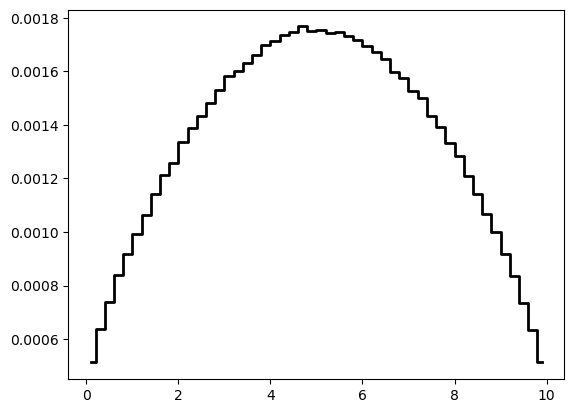

In [19]:
Jx = get_distribution_1D(samples_df_n,"x", bins,"wgt" ,S1)
plt.plot(Jx['x'],Jx['mean'], ds='steps-mid' ,color='black', label='Original', linewidth=2)
Jx

Integral de la corriente espacial, para chequear que de lo mismo que la integral de la corriente espectral

$J=\int dx \int dy \:J(x,y)= \sum_{i} \sum_{j} J(x_i,y_j) $   -> esta no va

$J=\int dx \int dy \:J(x,y)= \sum_{i} \sum_{j} J(x_i,y_j)\cdot\Delta x_i\cdot \Delta y_j\cdot\dfrac{1}{\Delta x \Delta y} $

Tener en cuenta que deltax= dxi*Nx

Chequear que J integrado en espacio o energia es lo mismo

In [21]:
S0 = 1.0
tally=sp.get_tally(name='leakage_salida_x_sin_mesh')     
data=tally.get_pandas_dataframe(nuclides=False)
data   

/Users/gregoire_lebreton/anaconda3/envs/internship/lib/python3.11/site-packages/openmc/tallies.py:279: RuntimeWarning: invalid value encountered in divide
  self._std_dev[nonzero] = np.sqrt((self.sum_sq[nonzero]/n -


,surface,particle,score,mean
0,6,neutron,current,0.013357


In [22]:
dA =100
data_mean=data['mean']*S0/(dA)
data_mean

0    0.000134
Name: mean, dtype: float64

In [23]:
S0 = 1.0
Npart = 1e8
xmin=0
xmax=10
ymin=0
ymax=10
dA=(xmax-xmin)*(ymax-ymin) 
Jn_track_mean=np.sum(samples_df_n['wgt']/Npart)*S0/dA
Jn_track_stdv=np.sqrt(sum(samples_df_n['wgt']**2/Npart**2))*S0/dA
Jn_track_total=ufloat(Jn_track_mean,Jn_track_stdv)
print('Corriente total de neutrones que sale del haz, calculada con tracks: {} [n/(cm² s)]'.format(Jn_track_total))
#print('Incerteza relativa: {:.1f} %'.format(Jn_track_stdv/Jn_track_mean*100.0))

print('Corriente total de neutrones que sale del haz, calculada con tallies: {} [n/(cm² s)]'.format(data_mean))
#print('Incerteza relativa: {:.1f} %'.format(Jn_tally_total.std_dev/Jn_tally_total.nominal_value*100.0))

Corriente total de neutrones que sale del haz, calculada con tracks: 0.00013357+/-0.00000012 [n/(cm² s)]
Corriente total de neutrones que sale del haz, calculada con tallies: 0    0.000134
Name: mean, dtype: float64 [n/(cm² s)]


In [24]:
tally=sp.get_tally(name='leakage_salida_x_con_mesh')     
mesh_filter=tally.find_filter(openmc.filter.MeshFilter)
data=tally.get_pandas_dataframe(nuclides=False)
data   

/Users/gregoire_lebreton/anaconda3/envs/internship/lib/python3.11/site-packages/openmc/tallies.py:279: RuntimeWarning: invalid value encountered in divide
  self._std_dev[nonzero] = np.sqrt((self.sum_sq[nonzero]/n -


surface particle mesh 1          score     mean
                         x  y  z                  
0        6  neutron      1  1  1  current 1.03e-04
1        6  neutron      2  1  1  current 1.27e-04
2        6  neutron      3  1  1  current 1.47e-04
3        6  neutron      4  1  1  current 1.68e-04
4        6  neutron      5  1  1  current 1.84e-04
5        6  neutron      6  1  1  current 1.99e-04
6        6  neutron      7  1  1  current 2.12e-04
7        6  neutron      8  1  1  current 2.28e-04
8        6  neutron      9  1  1  current 2.42e-04
9        6  neutron     10  1  1  current 2.52e-04
10       6  neutron     11  1  1  current 2.67e-04
11       6  neutron     12  1  1  current 2.77e-04
12       6  neutron     13  1  1  current 2.86e-04
13       6  neutron     14  1  1  current 2.97e-04
14       6  neutron     15  1  1  current 3.06e-04
15       6  neutron     16  1  1  current 3.16e-04
16       6  neutron     17  1  1  current 3.20e-04
17       6  neutron     18  1  1  current 3.26e-04
18       6  neutron     19  1  1  current 3.32e-04
19       6  neutron     20  1  1  current 3.40e-04
20       6  neutron     21  1  1  current 3.43e-04
21       6  neutron     22  1  1  current 3.47e-04
22       6  neutron     23  1  1  current 3.50e-04
23       6  neutron     24  1  1  current 3.53e-04
24       6  neutron     25  1  1  current 3.50e-04
25       6  neutron     26  1  1  current 3.51e-04
26       6  neutron     27  1  1  current 3.48e-04
27       6  neutron     28  1  1  current 3.49e-04
28       6  neutron     29  1  1  current 3.46e-04
29       6  neutron     30  1  1  current 3.43e-04
30       6  neutron     31  1  1  current 3.39e-04
31       6  neutron     32  1  1  current 3.35e-04
32       6  neutron     33  1  1  current 3.29e-04
33       6  neutron     34  1  1  current 3.19e-04
34       6  neutron     35  1  1  current 3.15e-04
35       6  neutron     36  1  1  current 3.05e-04
36       6  neutron     37  1  1  current 3.00e-04
37       6  neutron     38  1  1  current 2.86e-04
38       6  neutron     39  1  1  current 2.78e-04
39       6  neutron     40  1  1  current 2.67e-04
40       6  neutron     41  1  1  current 2.57e-04
41       6  neutron     42  1  1  current 2.42e-04
42       6  neutron     43  1  1  current 2.29e-04
43       6  neutron     44  1  1  current 2.13e-04
44       6  neutron     45  1  1  current 2.00e-04
45       6  neutron     46  1  1  current 1.84e-04
46       6  neutron     47  1  1  current 1.67e-04
47       6  neutron     48  1  1  current 1.47e-04
48       6  neutron     49  1  1  current 1.27e-04
49       6  neutron     50  1  1  current 1.02e-04

50 0.0 10.0 10.0
1 0.0 10.0 10.0
1 9.999999999976694e-05 10.0 9.9999


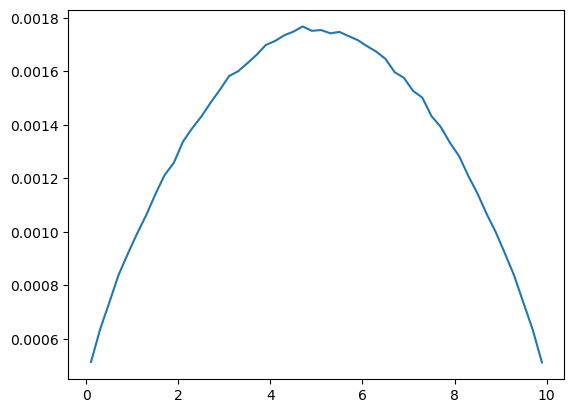

In [25]:
Nx=mesh_filter.mesh.dimension[0]
xmin=mesh_filter.mesh.lower_left[0]
xmax=mesh_filter.mesh.upper_right[0]
dx=xmax-xmin

Ny=mesh_filter.mesh.dimension[1]
ymin=mesh_filter.mesh.lower_left[1]
ymax=mesh_filter.mesh.upper_right[1]
dy=ymax-ymin

Nz=mesh_filter.mesh.dimension[2]
zmin=mesh_filter.mesh.lower_left[2]
zmax=mesh_filter.mesh.upper_right[2]
dz=zmax-zmin


print(Nx, xmin, xmax, dx)
print(Ny, ymin, ymax, dy)
print(Nz, zmin, zmax, dz)


data_mean=data['mean']*S0/(dx/Nx)

#data_stdv=data['stdv']*S0/(dA)
bins = np.linspace(xmin,xmax,51)
output_bins=0.5*(bins[1:]+bins[:-1])
#spectra_tallyn=pd.DataFrame(data=np.array([E,data_mean,data_stdv]).T,columns=['E','mean','stdv']

plt.plot(output_bins, data_mean)

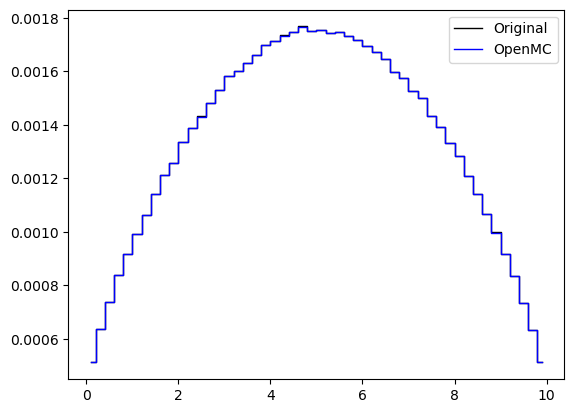

In [26]:
Jx = get_distribution_1D(samples_df_n,"x", bins,"wgt" ,S1)
plt.plot(Jx['x'],Jx['mean'] ,color='black', ds='steps-mid', label='Original', linewidth=1)
plt.plot(output_bins, data_mean, ds='steps-mid', color='blue', label='OpenMC', linewidth=1)
plt.legend()
plt.show()

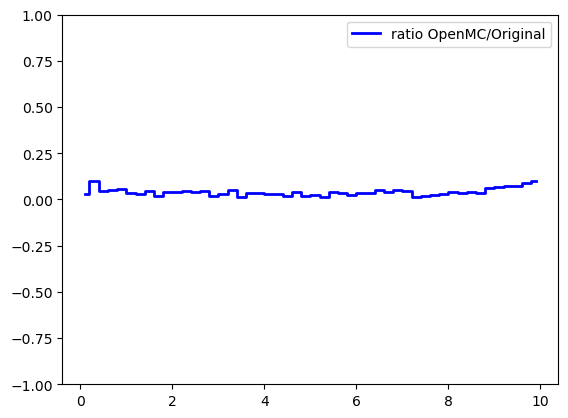

In [27]:
plt.plot(output_bins, (1-data_mean/Jx['mean'])*100, ds='steps-mid', color='blue', label='ratio OpenMC/Original', linewidth=2)
plt.ylim(-1,1)
plt.legend()

## Comparación de la corriente en función del varistor y. 

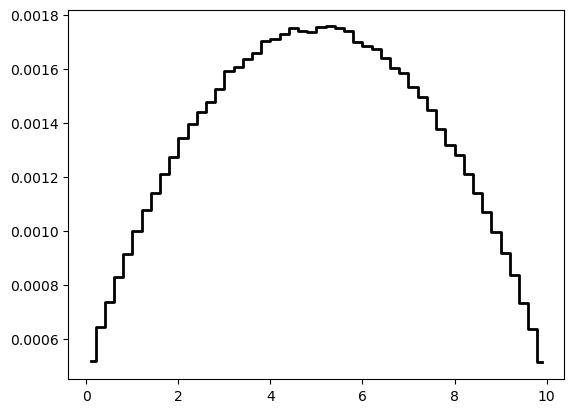

In [28]:
Jy = get_distribution_1D(samples_df_n,"y", bins,"wgt" ,S1)
plt.plot(Jy['y'],Jy['mean'], ds='steps-mid' ,color='black', label='Original', linewidth=2)

In [30]:
S0 = 1.0
tally=sp.get_tally(name='leakage_salida_y_sin_mesh')     
data=tally.get_pandas_dataframe(nuclides=False)
data   

/Users/gregoire_lebreton/anaconda3/envs/internship/lib/python3.11/site-packages/openmc/tallies.py:279: RuntimeWarning: invalid value encountered in divide
  self._std_dev[nonzero] = np.sqrt((self.sum_sq[nonzero]/n -


,surface,particle,score,mean
0,6,neutron,current,0.013357


In [31]:
dA =100
data_mean=data['mean']*S0/(dA)
data_mean

0    0.000134
Name: mean, dtype: float64

In [32]:
S0 = 1.0
Npart = 1e8
xmin=0
xmax=10
ymin=0
ymax=10
dA=(xmax-xmin)*(ymax-ymin) 
Jn_track_mean=np.sum(samples_df_n['wgt']/Npart)*S0/dA
Jn_track_stdv=np.sqrt(sum(samples_df_n['wgt']**2/Npart**2))*S0/dA
Jn_track_total=ufloat(Jn_track_mean,Jn_track_stdv)
print('Corriente total de neutrones que sale del haz, calculada con tracks: {} [n/(cm² s)]'.format(Jn_track_total))
#print('Incerteza relativa: {:.1f} %'.format(Jn_track_stdv/Jn_track_mean*100.0))

print('Corriente total de neutrones que sale del haz, calculada con tallies: {} [n/(cm² s)]'.format(data_mean))
#print('Incerteza relativa: {:.1f} %'.format(Jn_tally_total.std_dev/Jn_tally_total.nominal_value*100.0))

Corriente total de neutrones que sale del haz, calculada con tracks: 0.00013357+/-0.00000012 [n/(cm² s)]
Corriente total de neutrones que sale del haz, calculada con tallies: 0    0.000134
Name: mean, dtype: float64 [n/(cm² s)]


In [33]:
tally=sp.get_tally(name='leakage_salida_y_con_mesh')     
mesh_filter=tally.find_filter(openmc.filter.MeshFilter)
data=tally.get_pandas_dataframe(nuclides=False)
data   

/Users/gregoire_lebreton/anaconda3/envs/internship/lib/python3.11/site-packages/openmc/tallies.py:279: RuntimeWarning: invalid value encountered in divide
  self._std_dev[nonzero] = np.sqrt((self.sum_sq[nonzero]/n -


surface mesh 2        particle    score     mean
                x   y  z                           
0        6      1   1  1  neutron  current 1.03e-04
1        6      1   2  1  neutron  current 1.29e-04
2        6      1   3  1  neutron  current 1.47e-04
3        6      1   4  1  neutron  current 1.65e-04
4        6      1   5  1  neutron  current 1.83e-04
5        6      1   6  1  neutron  current 2.00e-04
6        6      1   7  1  neutron  current 2.15e-04
7        6      1   8  1  neutron  current 2.28e-04
8        6      1   9  1  neutron  current 2.42e-04
9        6      1  10  1  neutron  current 2.54e-04
10       6      1  11  1  neutron  current 2.69e-04
11       6      1  12  1  neutron  current 2.79e-04
12       6      1  13  1  neutron  current 2.88e-04
13       6      1  14  1  neutron  current 2.95e-04
14       6      1  15  1  neutron  current 3.05e-04
15       6      1  16  1  neutron  current 3.18e-04
16       6      1  17  1  neutron  current 3.22e-04
17       6      1  18  1  neutron  current 3.27e-04
18       6      1  19  1  neutron  current 3.32e-04
19       6      1  20  1  neutron  current 3.40e-04
20       6      1  21  1  neutron  current 3.42e-04
21       6      1  22  1  neutron  current 3.46e-04
22       6      1  23  1  neutron  current 3.50e-04
23       6      1  24  1  neutron  current 3.48e-04
24       6      1  25  1  neutron  current 3.47e-04
25       6      1  26  1  neutron  current 3.51e-04
26       6      1  27  1  neutron  current 3.51e-04
27       6      1  28  1  neutron  current 3.50e-04
28       6      1  29  1  neutron  current 3.48e-04
29       6      1  30  1  neutron  current 3.40e-04
30       6      1  31  1  neutron  current 3.37e-04
31       6      1  32  1  neutron  current 3.34e-04
32       6      1  33  1  neutron  current 3.28e-04
33       6      1  34  1  neutron  current 3.20e-04
34       6      1  35  1  neutron  current 3.17e-04
35       6      1  36  1  neutron  current 3.06e-04
36       6      1  37  1  neutron  current 2.99e-04
37       6      1  38  1  neutron  current 2.89e-04
38       6      1  39  1  neutron  current 2.76e-04
39       6      1  40  1  neutron  current 2.63e-04
40       6      1  41  1  neutron  current 2.56e-04
41       6      1  42  1  neutron  current 2.42e-04
42       6      1  43  1  neutron  current 2.28e-04
43       6      1  44  1  neutron  current 2.14e-04
44       6      1  45  1  neutron  current 1.99e-04
45       6      1  46  1  neutron  current 1.83e-04
46       6      1  47  1  neutron  current 1.67e-04
47       6      1  48  1  neutron  current 1.47e-04
48       6      1  49  1  neutron  current 1.27e-04
49       6      1  50  1  neutron  current 1.02e-04

In [34]:
sum(data['mean'])

0.013351619999999998

1 0.0 10.0 10.0
50 0.0 10.0 10.0
1 9.999999999976694e-05 10.0 9.9999


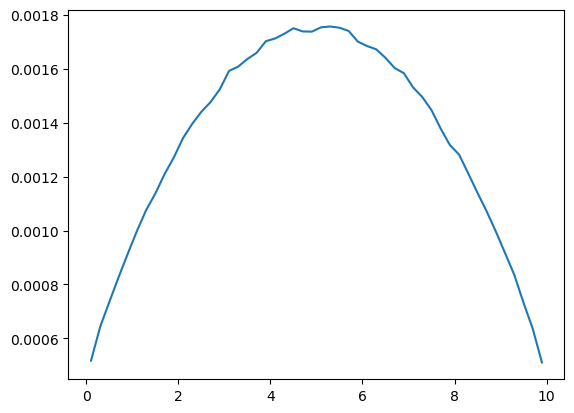

In [35]:
Nx=mesh_filter.mesh.dimension[0]
xmin=mesh_filter.mesh.lower_left[0]
xmax=mesh_filter.mesh.upper_right[0]
dx=xmax-xmin

Ny=mesh_filter.mesh.dimension[1]
ymin=mesh_filter.mesh.lower_left[1]
ymax=mesh_filter.mesh.upper_right[1]
dy=ymax-ymin

Nz=mesh_filter.mesh.dimension[2]
zmin=mesh_filter.mesh.lower_left[2]
zmax=mesh_filter.mesh.upper_right[2]
dz=zmax-zmin


print(Nx, xmin, xmax, dx)
print(Ny, ymin, ymax, dy)
print(Nz, zmin, zmax, dz)


data_mean=data['mean']*S0/(dy/Ny)

#data_stdv=data['stdv']*S0/(dA)
bins = np.linspace(ymin,ymax,51)
output_bins=0.5*(bins[1:]+bins[:-1])
#spectra_tally=pd.DataFrame(data=np.array([E,data_mean,data_stdv]).T,columns=['E','mean','stdv']

plt.plot(output_bins, data_mean)

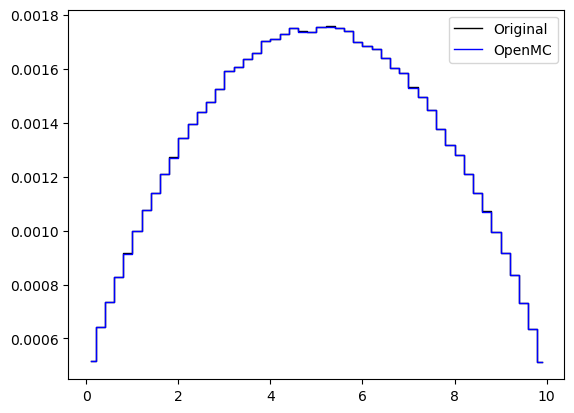

In [36]:
Jy = get_distribution_1D(samples_df_n,"y", bins,"wgt" ,S1)
plt.plot(Jy['y'],Jy['mean'] ,color='black', ds='steps-mid', label='Original', linewidth=1)
plt.plot(output_bins, data_mean, ds='steps-mid', color='blue', label='OpenMC', linewidth=1)
plt.legend()
plt.show()

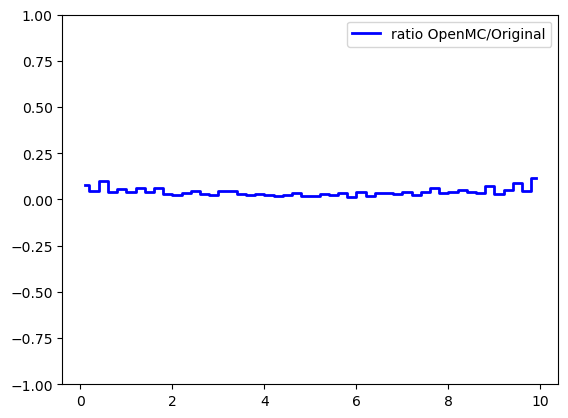

In [37]:
plt.plot(output_bins, (1-data_mean/Jy['mean'])*100, ds='steps-mid', color='blue', label='ratio OpenMC/Original', linewidth=2)
plt.ylim(-1,1)
plt.legend()

## Comparación de la corriente en función del varistor x y y. 

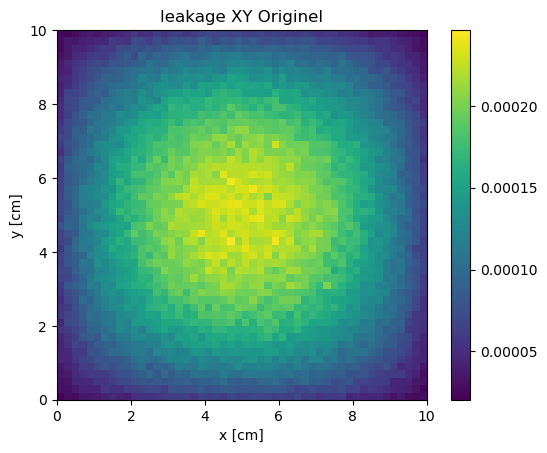

In [90]:
bins=np.linspace(0,10,51) 
xbins=bins
ybins=bins
Jxy=get_distribution_2D(samples_df_n,'x','y',xbins,ybins,'wgt',S1)[0]

plt.imshow(Jxy,extent=(0,10,0,10),origin='lower',interpolation='None')
plt.colorbar()
plt.xlabel('x [cm]')
plt.ylabel('y [cm]')
plt.title('leakage XY Originel')
plt.show()

MeshFilter
	Mesh ID        =	3
	ID             =	3
	Translation    =	None

50 0.0 10.0 10.0
50 0.0 10.0 10.0
1 9.999999999976694e-05 10.0 9.9999


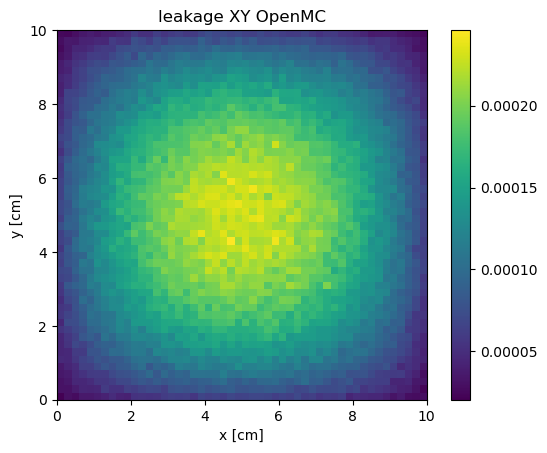

In [91]:
tally=sp.get_tally(name='leak_xy')       
mesh_filter=tally.find_filter(openmc.filter.MeshFilter)
data=tally.get_slice(scores=['current'])

print(mesh_filter)

Nx=mesh_filter.mesh.dimension[0]
xmin=mesh_filter.mesh.lower_left[0]
xmax=mesh_filter.mesh.upper_right[0]
dx=xmax-xmin

Ny=mesh_filter.mesh.dimension[1]
ymin=mesh_filter.mesh.lower_left[1]
ymax=mesh_filter.mesh.upper_right[1]
dy=ymax-ymin

Nz=mesh_filter.mesh.dimension[2]
zmin=mesh_filter.mesh.lower_left[2]
zmax=mesh_filter.mesh.upper_right[2]
dz=zmax-zmin

print(Nx, xmin, xmax, dx)
print(Ny, ymin, ymax, dy)
print(Nz, zmin, zmax, dz)

data.mean.shape=(Nx,Ny)
#data.std_dev.shape=(Nx,Ny)

data_mean = data.mean*S0/(dx/Nx*dy/Ny)

#data_stdv=data['stdv']*S0/(dA)

plt.imshow(data_mean, origin='lower', interpolation='none', extent=(xmin,xmax,ymin,ymax), cmap='viridis')
plt.colorbar()
plt.xlabel('x [cm]')
plt.ylabel('y [cm]')
plt.title('leakage XY OpenMC')
plt.show()


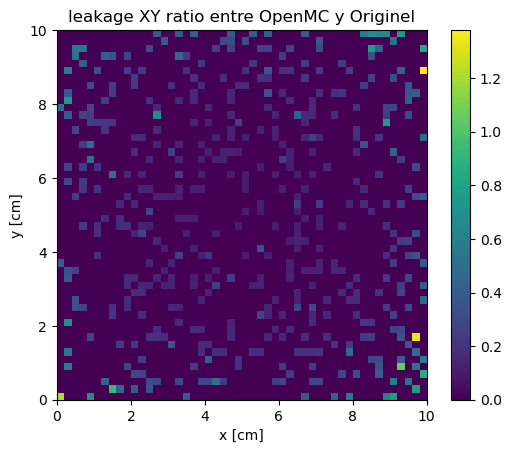

In [92]:
plt.imshow(((Jxy-data_mean)/Jxy)*100, origin='lower', interpolation='none', extent=(xmin,xmax,ymin,ymax), cmap='viridis')
plt.colorbar()
plt.xlabel('x [cm]')
plt.ylabel('y [cm]')
plt.title('leakage XY ratio entre OpenMC y Originel')
plt.show()

## Creación de un nuevo DataFrame en coordenadas esféricas.

In [141]:
def xyz_to_sph(df):
    track=pd.DataFrame()
    track['R2']=(df['x']**2+df['y']**2)
    track['psi']=np.arctan2(df['y'],df['x'])#*180/np.pi
    track['phi']=np.arctan2(df['v'],df['u'])#*180/np.pi
    track['theta']=np.arctan2(np.sqrt(df['u']**2+df['v']**2),df['w'])#*180/np.pi
    track['mu']=np.cos(track['theta'])
    # track['theta']=np.arccos(df['w'])#*180/np.pi
   # track['E']=np.log(Emax/df['ekin'])    #esto va a letargia aunque se llame E
    track['E']=df['E']    #esto va a letargia aunque se llame E
    #track['wgt']=np.log(Emax/df['ekin'])*df['weight']  #cambio de variable para una correlacion mas sencilla
    track['wgt']=df['wgt']  #cambio de variable para una correlacion mas sencilla
    return track

In [142]:
samples_esf = xyz_to_sph(samples_df_n)
samples_esf

,R2,psi,phi,theta,mu,E,wgt
0,38.911871,1.547172,-2.010302,0.867084,0.647053,4.687322e-08,1.0
1,118.323959,0.463454,-0.150094,0.515186,0.870201,9.009292e-01,1.0
2,24.251781,0.989225,-1.270659,0.475429,0.889096,7.095236e-01,1.0
3,69.149008,0.371354,-0.152951,0.455808,0.897906,1.365903e-07,1.0
4,107.410657,0.430681,-0.093142,1.102377,0.451477,4.270429e-02,1.0
...,...,...,...,...,...,...,...
1603123,49.697765,0.940322,-1.191462,0.296771,0.956286,5.603027e-08,1.0
1603124,129.129609,0.902916,2.321387,0.354753,0.937732,7.832237e-02,1.0
1603125,76.131273,1.247414,0.083989,0.247756,0.969465,2.686202e-02,1.0
1603126,21.034748,0.689854,1.147796,0.476884,0.888430,3.306267e-07,1.0


## Comparación de la corriente en función del varistor theta=atg

(array([ 59376., 158996., 216320., 229720., 210824., 176960., 134715.,
         89300.,  46473.,  12975.]),
 array([7.58215480e-04, 1.57686647e-01, 3.14615079e-01, 4.71543510e-01,
        6.28471942e-01, 7.85400373e-01, 9.42328805e-01, 1.09925724e+00,
        1.25618567e+00, 1.41311410e+00, 1.57004253e+00]),
 <BarContainer object of 10 artists>)

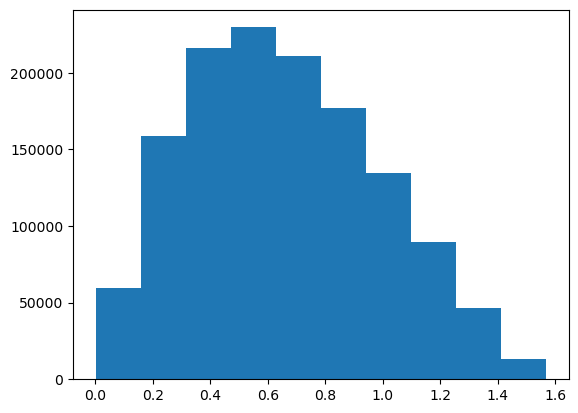

In [96]:
plt.hist(samples_esf['theta'])

/var/folders/xj/34z2kptx3vlg9_440kwc5_sc0000gn/T/ipykernel_784/2232481116.py:5: RuntimeWarning: invalid value encountered in divide
  return pd.DataFrame(data=np.array([output_bins,output_mean,output_stdv,np.nan_to_num(output_stdv/output_mean)]).T,columns=[xlabel,'mean','stdv','erel'])


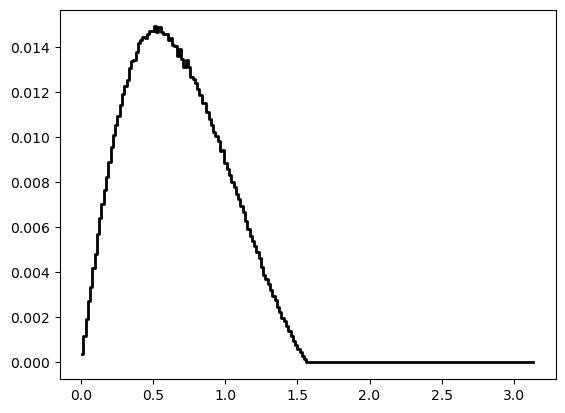

In [97]:
bins=np.linspace(0,np.pi,200)
Jtheta = get_distribution_1D(samples_esf,"theta", bins,"wgt" ,S1)
plt.plot(Jtheta['theta'],Jtheta['mean'], ds='steps-mid' ,color='black', label='Original', linewidth=2)

In [98]:
tally=sp.get_tally(name='leakage_salida_theta')     
mesh_filter=tally.find_filter(openmc.filter.PolarFilter)
data=tally.get_pandas_dataframe(nuclides=False)
data   

,surface,polar low [rad],polar high [rad],particle,score,mean
0,6,0.000000,0.015787,neutron,current,0.000006
1,6,0.015787,0.031574,neutron,current,0.000019
2,6,0.031574,0.047361,neutron,current,0.000030
3,6,0.047361,0.063148,neutron,current,0.000043
4,6,0.063148,0.078934,neutron,current,0.000053
...,...,...,...,...,...,...
194,6,3.062658,3.078445,neutron,current,0.000000
195,6,3.078445,3.094232,neutron,current,0.000000
196,6,3.094232,3.110019,neutron,current,0.000000
197,6,3.110019,3.125806,neutron,current,0.000000


In [99]:
dS=Lx*Ly
data.columns=['surface','theta_min','theta_max','particle','score','mean']
theta_min=data['theta_min'].values
theta_max=data['theta_max'].values
theta=(theta_min+theta_max)/2.0
dtheta=theta_max-theta_min
#dtheta=-np.pi*(np.cos(theta_max)-np.cos(theta_min))
data_mean_theta=data['mean']*S0/(dtheta)
#data_stdv_theta=data['stdv']*S0/(dtheta)

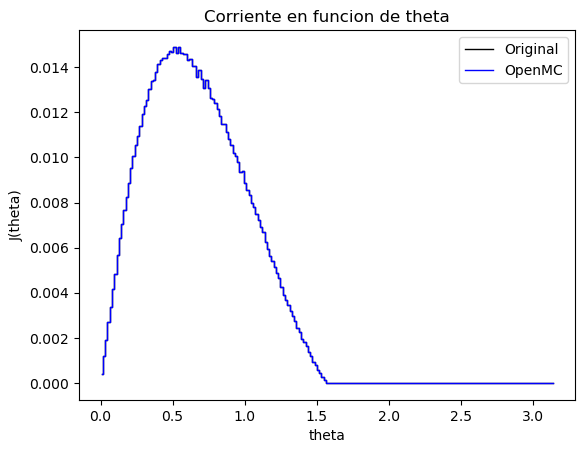

In [100]:
plt.plot(Jtheta['theta'],Jtheta['mean'] ,color='black', ds='steps-mid', label='Original', linewidth=1)
plt.plot(theta, data_mean_theta, ds='steps-mid', color='blue', label='OpenMC', linewidth=1)
plt.legend()
plt.title('Corriente en funcion de theta')
plt.xlabel('theta')
plt.ylabel('J(theta)')
plt.show()

In [101]:
output_bins=0.5*(bins[1:]+bins[:-1])

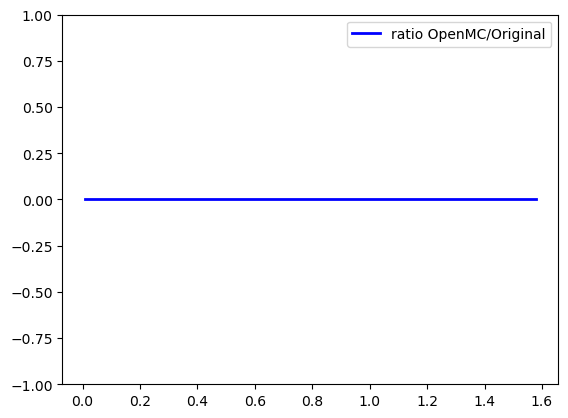

In [102]:
plt.plot(output_bins, (1-data_mean_theta/Jtheta['mean'])*100, ds='steps-mid', color='blue', label='ratio OpenMC/Original', linewidth=2)
plt.ylim(-1,1)
plt.legend()

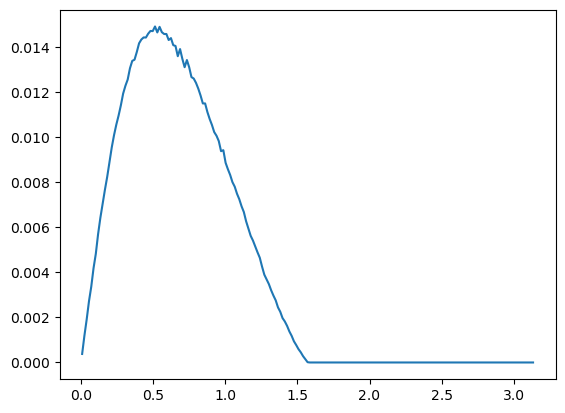

In [103]:
plt.plot(theta,data_mean_theta)

## Comparación de la corriente en función del varistor mu con theta=atg

/var/folders/xj/34z2kptx3vlg9_440kwc5_sc0000gn/T/ipykernel_784/2232481116.py:5: RuntimeWarning: invalid value encountered in divide
  return pd.DataFrame(data=np.array([output_bins,output_mean,output_stdv,np.nan_to_num(output_stdv/output_mean)]).T,columns=[xlabel,'mean','stdv','erel'])


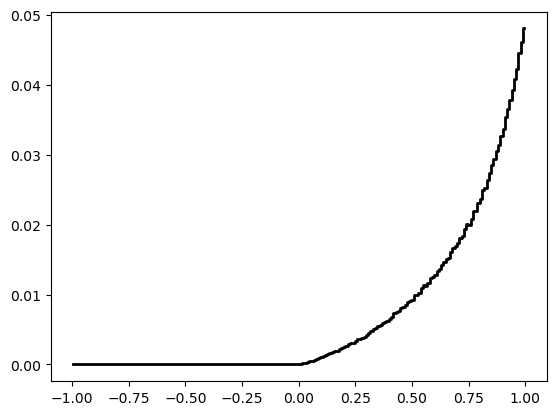

In [104]:
bins=np.linspace(-1,1,200)
Jmu = get_distribution_1D(samples_esf,"mu", bins,"wgt" ,S1)
plt.plot(Jmu['mu'],Jmu['mean'], ds='steps-mid' ,color='black', label='Original', linewidth=2)

In [105]:
tally=sp.get_tally(name='leakage_salida_mu')     
mesh_filter=tally.find_filter(openmc.filter.MuFilter)
data=tally.get_pandas_dataframe(nuclides=False)
data   

,surface,mu low,mu high,particle,score,mean
0,6,-1.00,-0.96,neutron,current,0.000017
1,6,-0.96,-0.92,neutron,current,0.000021
2,6,-0.92,-0.88,neutron,current,0.000024
3,6,-0.88,-0.84,neutron,current,0.000024
4,6,-0.84,-0.80,neutron,current,0.000027
5,6,-0.80,-0.76,neutron,current,0.000027
6,6,-0.76,-0.72,neutron,current,0.000029
7,6,-0.72,-0.68,neutron,current,0.000031
8,6,-0.68,-0.64,neutron,current,0.000033
9,6,-0.64,-0.60,neutron,current,0.000034


In [106]:
dS=Lx*Ly
data.columns=['surface','mu_min','mu_max','particle','score','mean']
mu_min=data['mu_min'].values
mu_max=data['mu_max'].values
mu=(mu_min+mu_max)/2.0
dmu=mu_max-mu_min
data_mean_mu=data['mean']*S0/(dmu)
#data_stdv_mu=data['stdv']*S0/(dmu)

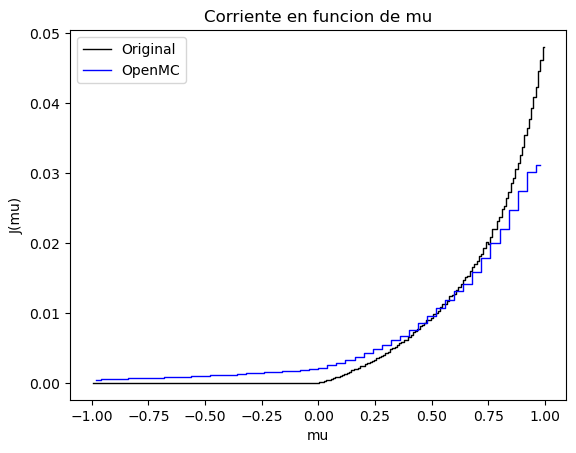

In [107]:
plt.plot(Jmu['mu'],Jmu['mean'] ,color='black', ds='steps-mid', label='Original', linewidth=1)
plt.plot(mu, data_mean_mu, ds='steps-mid', color='blue', label='OpenMC', linewidth=1)
plt.legend()
plt.title('Corriente en funcion de mu')
plt.xlabel('mu')
plt.ylabel('J(mu)')
plt.show()
plt.show()

## Comparación de la corriente en función del varistor cos(theta)

In [108]:
tally=sp.get_tally(name='leakage_salida_theta')     
mesh_filter=tally.find_filter(openmc.filter.PolarFilter)
data=tally.get_pandas_dataframe(nuclides=False)
data   

,surface,polar low [rad],polar high [rad],particle,score,mean
0,6,0.000000,0.015787,neutron,current,0.000006
1,6,0.015787,0.031574,neutron,current,0.000019
2,6,0.031574,0.047361,neutron,current,0.000030
3,6,0.047361,0.063148,neutron,current,0.000043
4,6,0.063148,0.078934,neutron,current,0.000053
...,...,...,...,...,...,...
194,6,3.062658,3.078445,neutron,current,0.000000
195,6,3.078445,3.094232,neutron,current,0.000000
196,6,3.094232,3.110019,neutron,current,0.000000
197,6,3.110019,3.125806,neutron,current,0.000000


In [109]:
dS=Lx*Ly
data.columns=['surface','theta_min','theta_max','particle','score','mean']
theta_min=data['theta_min'].values
theta_max=data['theta_max'].values
dtheta=theta_max-theta_min
mu=(np.cos(theta_min)+np.cos(theta_max))/2.0
dmu=np.cos(theta_max)-np.cos(theta_min)
data_mean_theta=data['mean']*S0/(dtheta)
#data_stdv_mu=data['stdv']*S0/(dmu)

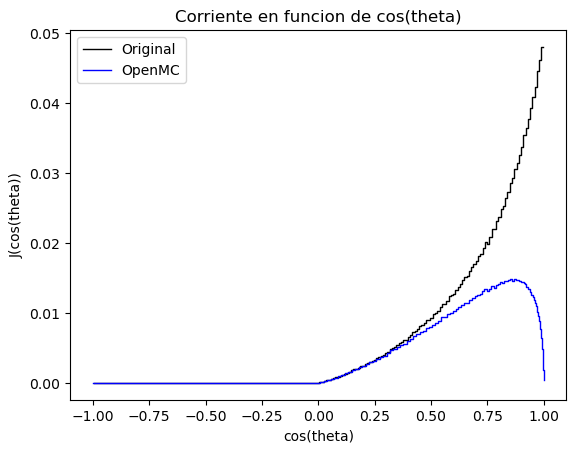

In [110]:
plt.plot(Jmu['mu'],Jmu['mean'] ,color='black', ds='steps-mid', label='Original', linewidth=1)
plt.plot(mu, data_mean_theta, ds='steps-mid', color='blue', label='OpenMC', linewidth=1)
plt.title('Corriente en funcion de cos(theta)')
plt.xlabel('cos(theta)')
plt.ylabel('J(cos(theta))')
plt.legend()
plt.show()

## Corriente theta con theta=atg

In [111]:
def xyz_to_sph(df):
    track=pd.DataFrame()
    track['R2']=(df['x']**2+df['y']**2)
    track['psi']=np.arctan2(df['y'],df['x'])#*180/np.pi
    track['phi']=np.arctan2(df['v'],df['u'])#*180/np.pi
    #track['theta']=np.arctan2(np.sqrt(df['u']**2+df['v']**2),df['w'])#*180/np.pi
    track['theta']=np.arccos(df['w'])#*180/np.pi
    track['mu']=np.cos(track['theta'])
   # track['E']=np.log(Emax/df['ekin'])    #esto va a letargia aunque se llame E
    track['E']=df['E']    #esto va a letargia aunque se llame E
    #track['wgt']=np.log(Emax/df['ekin'])*df['weight']  #cambio de variable para una correlacion mas sencilla
    track['wgt']=df['wgt']  #cambio de variable para una correlacion mas sencilla
    return track

In [112]:
samples_esf = xyz_to_sph(samples_df_n)
samples_esf

,R2,psi,phi,theta,mu,E,wgt
0,38.911871,1.547172,-2.010302,0.867084,0.647053,4.687322e-08,1.0
1,118.323959,0.463454,-0.150094,0.515186,0.870201,9.009292e-01,1.0
2,24.251781,0.989225,-1.270659,0.475429,0.889096,7.095236e-01,1.0
3,69.149008,0.371354,-0.152951,0.455808,0.897906,1.365903e-07,1.0
4,107.410657,0.430681,-0.093142,1.102377,0.451477,4.270429e-02,1.0
...,...,...,...,...,...,...,...
1603123,49.697765,0.940322,-1.191462,0.296771,0.956286,5.603027e-08,1.0
1603124,129.129609,0.902916,2.321387,0.354753,0.937732,7.832237e-02,1.0
1603125,76.131273,1.247414,0.083989,0.247756,0.969465,2.686202e-02,1.0
1603126,21.034748,0.689854,1.147796,0.476884,0.888430,3.306267e-07,1.0


(array([ 59376., 158996., 216320., 229720., 210824., 176960., 134715.,
         89300.,  46473.,  12975.]),
 array([7.58215480e-04, 1.57686647e-01, 3.14615079e-01, 4.71543510e-01,
        6.28471942e-01, 7.85400373e-01, 9.42328805e-01, 1.09925724e+00,
        1.25618567e+00, 1.41311410e+00, 1.57004253e+00]),
 <BarContainer object of 10 artists>)

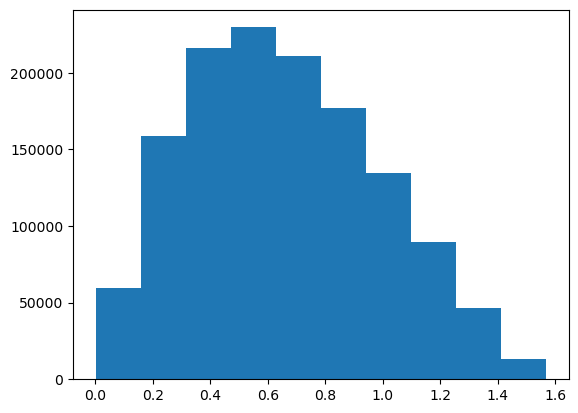

In [113]:
plt.hist(samples_esf['theta'])

/var/folders/xj/34z2kptx3vlg9_440kwc5_sc0000gn/T/ipykernel_784/2232481116.py:5: RuntimeWarning: invalid value encountered in divide
  return pd.DataFrame(data=np.array([output_bins,output_mean,output_stdv,np.nan_to_num(output_stdv/output_mean)]).T,columns=[xlabel,'mean','stdv','erel'])


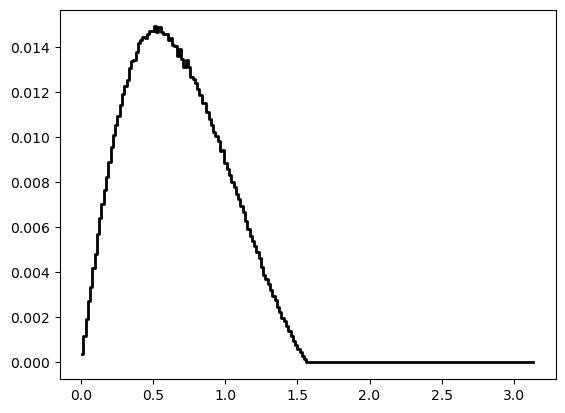

In [114]:
bins=np.linspace(0,np.pi,200)
Jtheta = get_distribution_1D(samples_esf,"theta", bins,"wgt" ,S1)
plt.plot(Jtheta['theta'],Jtheta['mean'], ds='steps-mid' ,color='black', label='Original', linewidth=2)

In [115]:
tally=sp.get_tally(name='leakage_salida_theta')     
mesh_filter=tally.find_filter(openmc.filter.PolarFilter)
data=tally.get_pandas_dataframe(nuclides=False)
data   

,surface,polar low [rad],polar high [rad],particle,score,mean
0,6,0.000000,0.015787,neutron,current,0.000006
1,6,0.015787,0.031574,neutron,current,0.000019
2,6,0.031574,0.047361,neutron,current,0.000030
3,6,0.047361,0.063148,neutron,current,0.000043
4,6,0.063148,0.078934,neutron,current,0.000053
...,...,...,...,...,...,...
194,6,3.062658,3.078445,neutron,current,0.000000
195,6,3.078445,3.094232,neutron,current,0.000000
196,6,3.094232,3.110019,neutron,current,0.000000
197,6,3.110019,3.125806,neutron,current,0.000000


In [116]:
dS=Lx*Ly
data.columns=['surface','theta_min','theta_max','particle','score','mean']
theta_min=data['theta_min'].values
theta_max=data['theta_max'].values
theta=(theta_min+theta_max)/2.0
dtheta=theta_max-theta_min
#dtheta=-np.pi*(np.cos(theta_max)-np.cos(theta_min))
data_mean_theta=data['mean']*S0/(dtheta)
#data_stdv_theta=data['stdv']*S0/(dtheta)

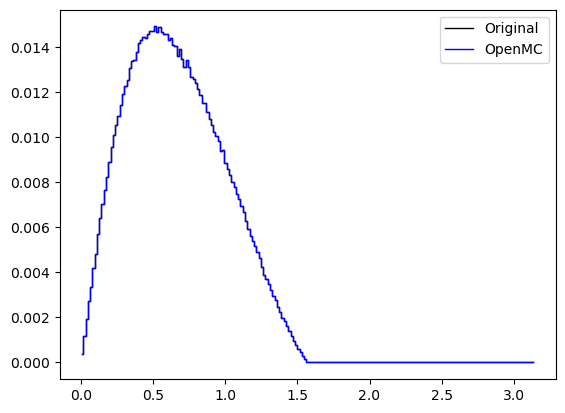

In [117]:
plt.plot(Jtheta['theta'],Jtheta['mean'] ,color='black', ds='steps-mid', label='Original', linewidth=1)
plt.plot(theta, data_mean_theta, ds='steps-mid', color='blue', label='OpenMC', linewidth=1)
plt.legend()
plt.show()

## Comparación de la corriente en función del varistor phi

In [118]:
samples_df_n

,id,type,E,x,y,z,u,v,w,t,wgt,px,py,pz,userflags
0,0,2112,4.687322e-08,0.147355,6.236197,10.0,-0.324415,-0.689984,0.647053,0.0,1.0,0.0,0.0,0.0,0
1,1,2112,9.009292e-01,9.730234,4.862768,10.0,0.487157,-0.073673,0.870201,0.0,1.0,0.0,0.0,0.0,0
2,2,2112,7.095236e-01,2.705275,4.115006,10.0,0.135326,-0.437258,0.889096,0.0,1.0,0.0,0.0,0.0,0
3,3,2112,1.365903e-07,7.748771,3.017542,10.0,0.435049,-0.067065,0.897906,0.0,1.0,0.0,0.0,0.0,0
4,4,2112,4.270429e-02,9.417497,4.326825,10.0,0.888415,-0.082989,0.451477,0.0,1.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1603123,1603123,2112,5.603027e-08,4.155975,5.694351,10.0,0.108289,-0.271645,0.956286,0.0,1.0,0.0,0.0,0.0,0
1603124,1603124,2112,7.832237e-02,7.037695,8.921909,10.0,-0.236924,0.254019,0.937732,0.0,1.0,0.0,0.0,0.0,0
1603125,1603125,2112,2.686202e-02,2.772691,8.273056,10.0,0.244365,0.020572,0.969465,0.0,1.0,0.0,0.0,0.0,0
1603126,1603126,2112,3.306267e-07,3.537642,2.918876,10.0,0.188424,0.418556,0.888430,0.0,1.0,0.0,0.0,0.0,0


In [119]:
def xyz_to_sph(df):
    track=pd.DataFrame()
    track['R2']=(df['x']**2+df['y']**2)
    track['psi']=np.arctan2(df['y'],df['x'])#*180/np.pi
    track['phi']=np.arctan2(df['v'],df['u'])#*180/np.pi
    track['theta']=np.arctan2(np.sqrt(df['u']**2+df['v']**2),df['w'])#*180/np.pi
    track['mu']=np.cos(track['theta'])
    # track['theta']=np.arccos(df['w'])#*180/np.pi
   # track['E']=np.log(Emax/df['ekin'])    #esto va a letargia aunque se llame E
    track['E']=df['E']    #esto va a letargia aunque se llame E
    #track['wgt']=np.log(Emax/df['ekin'])*df['weight']  #cambio de variable para una correlacion mas sencilla
    track['wgt']=df['wgt']  #cambio de variable para una correlacion mas sencilla
    return track

In [120]:
samples_esf = xyz_to_sph(samples_df_n)
samples_esf

,R2,psi,phi,theta,mu,E,wgt
0,38.911871,1.547172,-2.010302,0.867084,0.647053,4.687322e-08,1.0
1,118.323959,0.463454,-0.150094,0.515186,0.870201,9.009292e-01,1.0
2,24.251781,0.989225,-1.270659,0.475429,0.889096,7.095236e-01,1.0
3,69.149008,0.371354,-0.152951,0.455808,0.897906,1.365903e-07,1.0
4,107.410657,0.430681,-0.093142,1.102377,0.451477,4.270429e-02,1.0
...,...,...,...,...,...,...,...
1603123,49.697765,0.940322,-1.191462,0.296771,0.956286,5.603027e-08,1.0
1603124,129.129609,0.902916,2.321387,0.354753,0.937732,7.832237e-02,1.0
1603125,76.131273,1.247414,0.083989,0.247756,0.969465,2.686202e-02,1.0
1603126,21.034748,0.689854,1.147796,0.476884,0.888430,3.306267e-07,1.0


(array([133543., 134123., 133541., 133404., 133311., 133568., 133524.,
        133894., 133504., 133247.]),
 array([-3.14159136e+00, -2.51327330e+00, -1.88495525e+00, -1.25663719e+00,
        -6.28319139e-01, -1.08462342e-06,  6.28316970e-01,  1.25663502e+00,
         1.88495308e+00,  2.51327113e+00,  3.14158919e+00]),
 <BarContainer object of 10 artists>)

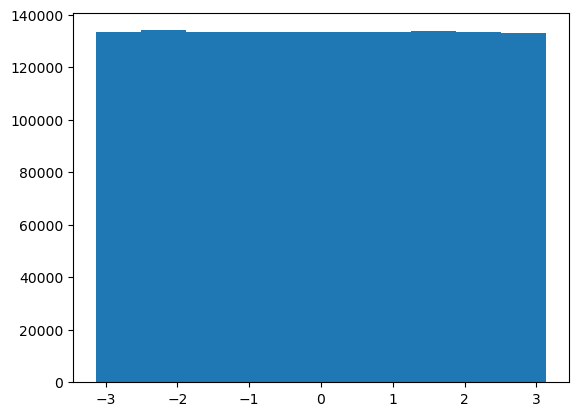

In [121]:
plt.hist(samples_esf['phi'])

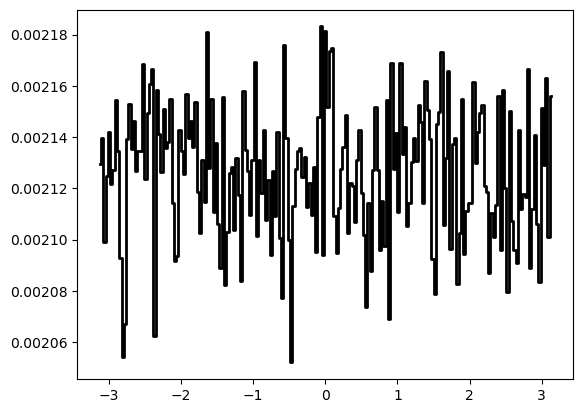

In [122]:
bins=np.linspace(-np.pi,np.pi,200)
Jphi = get_distribution_1D(samples_esf,"phi", bins,"wgt" ,S1)
plt.plot(Jphi['phi'],Jphi['mean'], ds='steps-mid' ,color='black', label='Original', linewidth=2)

In [123]:
tally=sp.get_tally(name='leakage_salida_phi')     
mesh_filter=tally.find_filter(openmc.filter.AzimuthalFilter)
data=tally.get_pandas_dataframe(nuclides=False)
data   

,surface,azimuthal low [rad],azimuthal high [rad],particle,score,mean
0,6,-3.141593,-3.110019,neutron,current,0.000067
1,6,-3.110019,-3.078445,neutron,current,0.000068
2,6,-3.078445,-3.046871,neutron,current,0.000066
3,6,-3.046871,-3.015297,neutron,current,0.000067
4,6,-3.015297,-2.983724,neutron,current,0.000068
...,...,...,...,...,...,...
194,6,2.983724,3.015297,neutron,current,0.000068
195,6,3.015297,3.046871,neutron,current,0.000067
196,6,3.046871,3.078445,neutron,current,0.000068
197,6,3.078445,3.110019,neutron,current,0.000066


In [124]:
dS=Lx*Ly
data.columns=['surface','phi_min','phi_max','particle','score','mean']
phi_min=data['phi_min'].values
phi_max=data['phi_max'].values
phi=(phi_min+phi_max)/2.0
dphi=phi_max-phi_min
data_mean_phi=data['mean']*S0/(dphi)
#data_stdv_phi=data['stdv']*S0/(dphi)

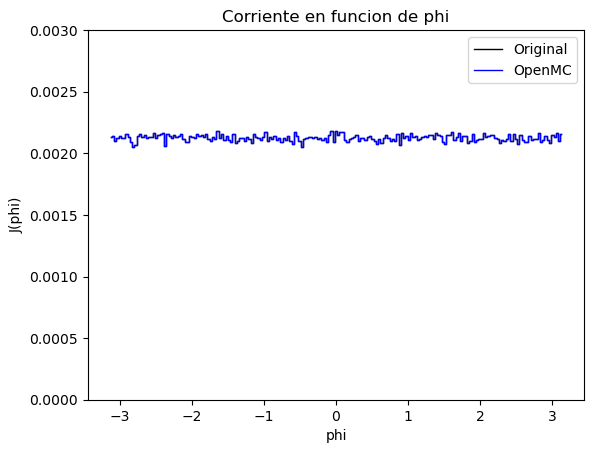

In [125]:
plt.plot(Jphi['phi'],Jphi['mean'] ,color='black', ds='steps-mid', label='Original', linewidth=1)
plt.plot(phi, data_mean_phi, ds='steps-mid', color='blue', label='OpenMC', linewidth=1)
plt.title('Corriente en funcion de phi')
plt.xlabel('phi')
plt.ylabel('J(phi)')
plt.ylim(0,0.003)
plt.legend()
plt.show()

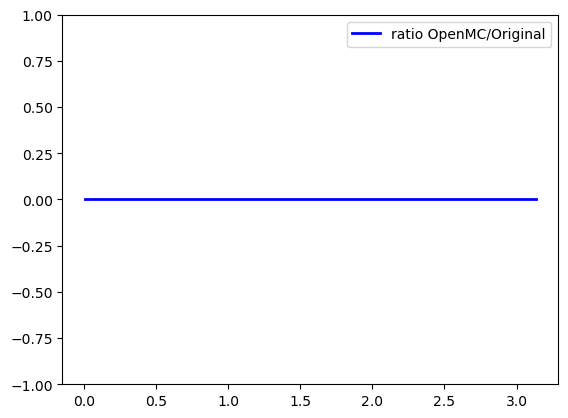

In [126]:
plt.plot(output_bins, (1-data_mean_phi/Jphi['mean'])*100, ds='steps-mid', color='blue', label='ratio OpenMC/Original', linewidth=2)
plt.ylim(-1,1)
plt.legend()

## Espectro

In [128]:
dS=Lx*Ly
tally=sp.get_tally(name='spectra_neutron_surf')
print(tally)
mesh_filter=tally.find_filter(openmc.filter.SurfaceFilter)
data=tally.get_pandas_dataframe(nuclides=False)

print(data)
data.columns=['Emin','Emax','particle','surface','score','mean']
print(data)
Emin=data['Emin'].values
Emax=data['Emax'].values
E=((Emin+Emax)/2.0)*1e-6
dE=(Emax-Emin)*1e-6

data_mean=data['mean']*S0/(dE)

Tally
	ID             =	9
	Name           =	spectra_neutron_surf
	Filters        =	EnergyFilter, ParticleFilter, SurfaceFilter
	Nuclides       =	total
	Scores         =	['current']
	Estimator      =	analog
     energy low [eV]  energy high [eV] particle  surface    score     mean
0           1.00e-05          1.15e-05  neutron        6  current 0.00e+00
1           1.15e-05          1.33e-05  neutron        6  current 0.00e+00
2           1.33e-05          1.53e-05  neutron        6  current 0.00e+00
3           1.53e-05          1.76e-05  neutron        6  current 0.00e+00
4           1.76e-05          2.03e-05  neutron        6  current 0.00e+00
..               ...               ...      ...      ...      ...      ...
195         9.85e+06          1.14e+07  neutron        6  current 0.00e+00
196         1.14e+07          1.31e+07  neutron        6  current 0.00e+00
197         1.31e+07          1.51e+07  neutron        6  current 0.00e+00
198         1.51e+07          1.74e+07  neut

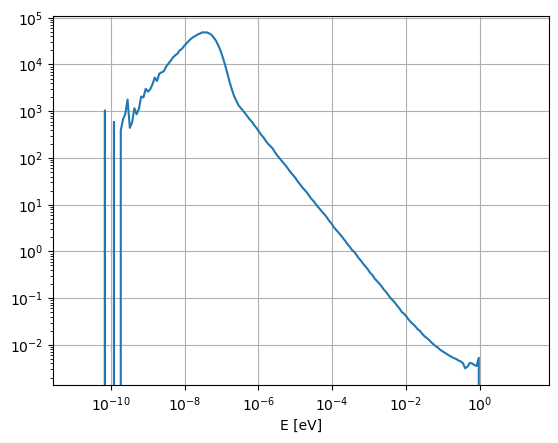

In [129]:
plt.loglog(E,data_mean)
plt.xlabel('E [eV]')
plt.grid()
plt.show()

                E  mean  stdv  erel
0    1.117270e-11   0.0   0.0   0.0
1    1.379314e-11   0.0   0.0   0.0
2    1.702819e-11   0.0   0.0   0.0
3    2.102198e-11   0.0   0.0   0.0
4    2.595247e-11   0.0   0.0   0.0
..            ...   ...   ...   ...
195  7.792241e+06   0.0   0.0   0.0
196  9.619833e+06   0.0   0.0   0.0
197  1.187607e+07   0.0   0.0   0.0
198  1.466148e+07   0.0   0.0   0.0
199  1.810018e+07   0.0   0.0   0.0

[200 rows x 4 columns]


/var/folders/xj/34z2kptx3vlg9_440kwc5_sc0000gn/T/ipykernel_784/2232481116.py:5: RuntimeWarning: invalid value encountered in divide
  return pd.DataFrame(data=np.array([output_bins,output_mean,output_stdv,np.nan_to_num(output_stdv/output_mean)]).T,columns=[xlabel,'mean','stdv','erel'])


(1e-12, 10)

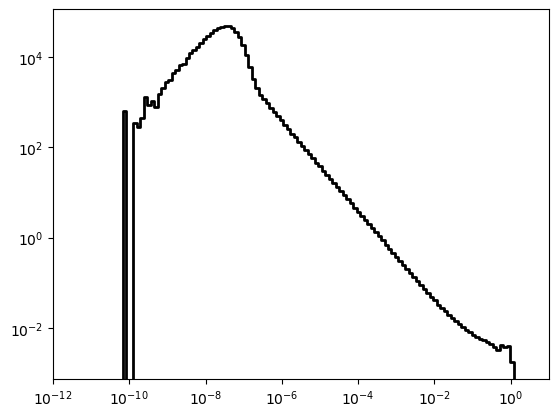

In [132]:
bins=np.logspace(np.log10(1e-11), np.log10(2e7), 201)
E_t = get_distribution_1D(samples_df_n,"E", bins,"wgt" ,S1)
print(E_t)
plt.loglog(E_t['E'],E_t['mean'], ds='steps-mid' ,color='black', label='Original', linewidth=2)
plt.xlim(1e-12,10)

Text(0.5, 1.0, 'Espectro')

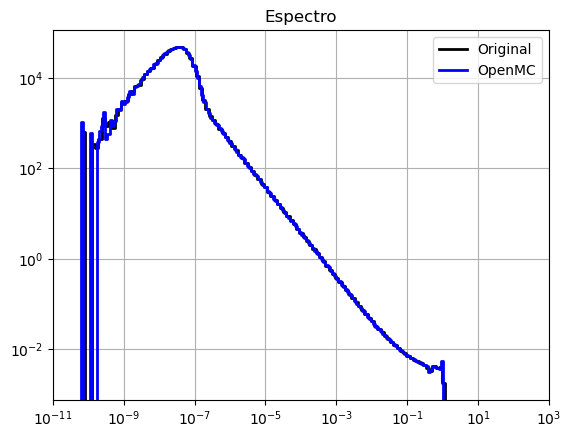

In [133]:
plt.loglog(E_t['E'],E_t['mean'], ds='steps-mid' ,color='black', label='Original', linewidth=2)
plt.loglog(E,data_mean,ds='steps-mid', color='blue',label='OpenMC', linewidth=2)
plt.xlim(1e-11,1e3)
plt.legend()
plt.grid()
plt.title('Espectro')

In [134]:
output_bins=0.5*(bins[1:]+bins[:-1])